# Classifying Depression

The National Institute of Mental Health describes depression as a “serious mood disorder”. Access to mental health services is challenging for people living in rural areas and they may not have the support they need. This may be due to their economic state, lack of education about these services, living at a distance from the services or friends and family, etc. The lack of access to mental health services may lead to increased rates of depression in people living in these areas.

In this project, we will be creating a classification model to predict whether or not someone is likely to be depressed, based on their sex, age, whether or not they’re married, the number of children they have, total family members, how much money they make, and their expenses.

For our project we extracted our data from [*Kaggle*](https://www.kaggle.com/datasets/diegobabativa/depression). The data comes from a study that was conducted on people living in rural areas.

# Preliminary exploratory data analysis

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
install.packages("themis")
library(themis)

options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.0     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

#### Reading and cleaning the data

In [2]:
depression_data <- read_csv("https://raw.githubusercontent.com/DonaldKLee/DSCI-100-Group-Project/main/data/b_depressed.csv") |>
    mutate(
        depression_result = as_factor(ifelse(depressed>0, "depressed", "not depressed")),
        assets=(gained_asset+durable_asset+save_asset),
        expenses=(living_expenses+other_expenses+farm_expenses)) |>
    select(sex, Age, Married, Number_children, total_members, assets, expenses, depression_result)

depression_data

Rows: 1429 Columns: 23
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (23): Survey_id, Ville_id, sex, Age, Married, Number_children, education...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


sex,Age,Married,Number_children,total_members,assets,expenses,depression_result
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,28,1,4,5,75174120,86258781,not depressed
1,23,1,3,5,75174120,86258781,depressed
1,22,1,3,5,75174120,86258781,not depressed
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1,66,0,0,1,87865276,79534107,depressed
1,51,1,1,5,75174120,86258781,not depressed
1,33,0,4,5,152396315,37702850,not depressed


###### Figure 1. Data from the depression dataset

## Summary of the training data

In [3]:
set.seed(2000)

depression_data_split <- initial_split(depression_data, prop=0.75, strata = depression_result)
depression_train <- training(depression_data_split)

depression_data_summary <- depression_train |>
    group_by(depression_result) |>
    summarize(mean_sex = round(mean(sex, na.rm = TRUE)), 
              mean_age = mean(Age, na.rm = TRUE), 
              mean_married = round(mean(Married, na.rm = TRUE)),
              mean_number_children = round(mean(Number_children, na.rm = TRUE)),
              mean_total_members = round(mean(total_members, na.rm = TRUE)),
              mean_assets = mean(assets, na.rm = TRUE),
              mean_expenses = mean(expenses, na.rm = TRUE),
              n=n())
    
depression_data_summary

depression_result,mean_sex,mean_age,mean_married,mean_number_children,mean_total_members,mean_assets,mean_expenses,n
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
not depressed,1,33.95633,1,3,5,88034652,100433599,893
depressed,1,38.09551,1,3,5,88954426,100347510,178


###### Figure 2. Summary of the data from the depression dataset

## Data Visualization

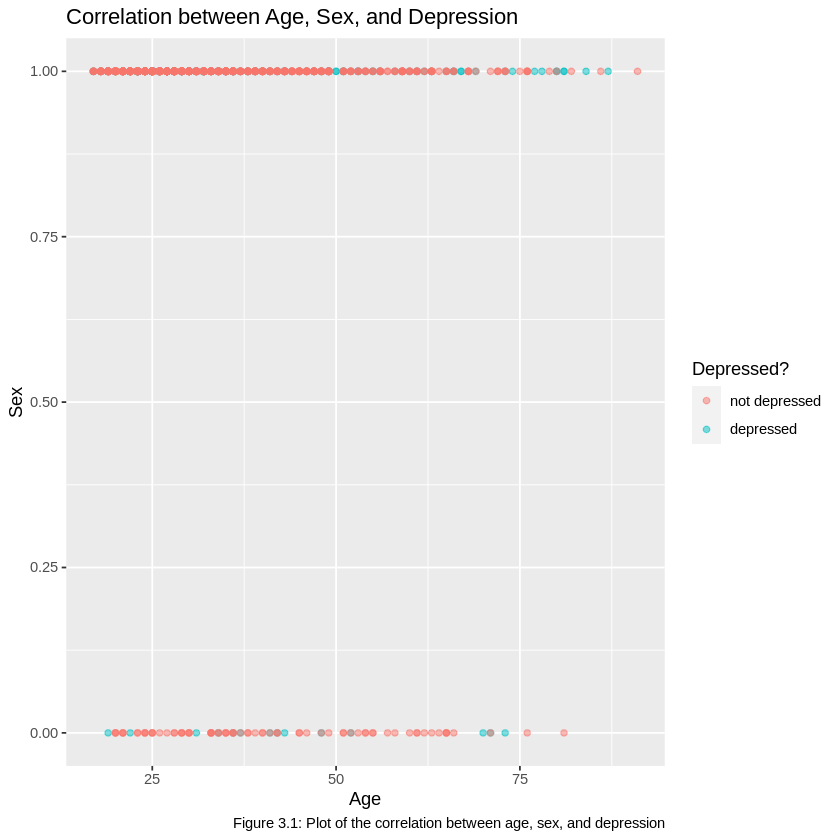

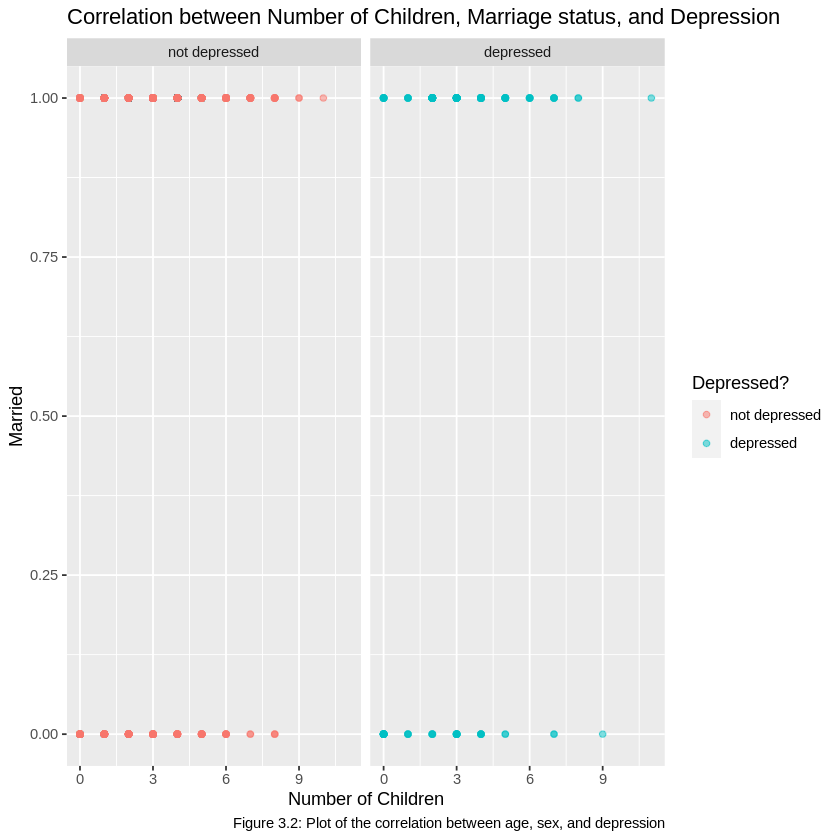

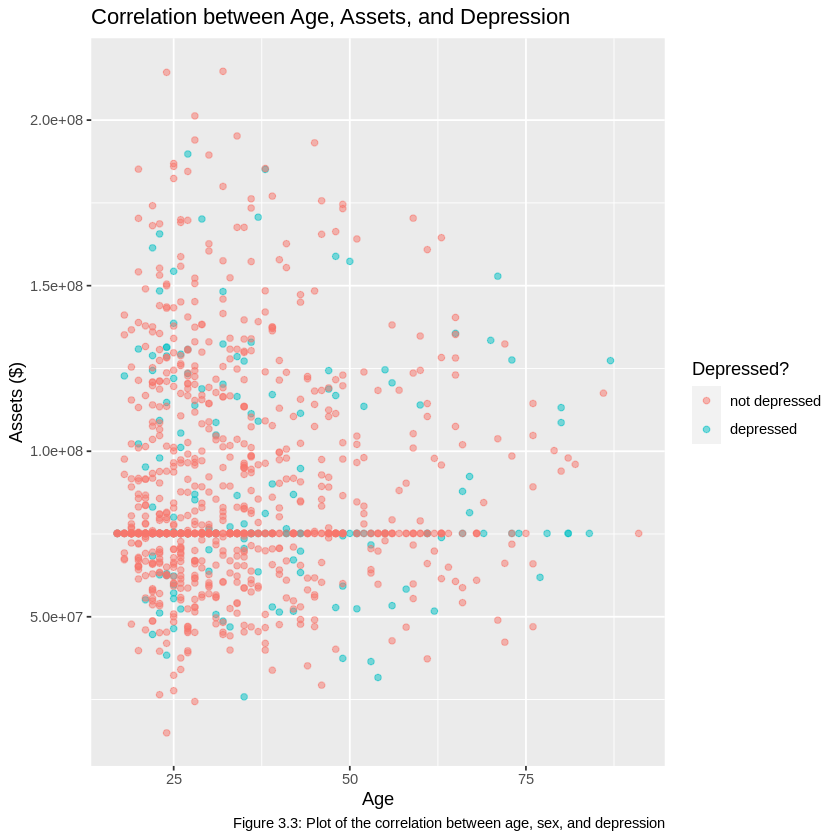

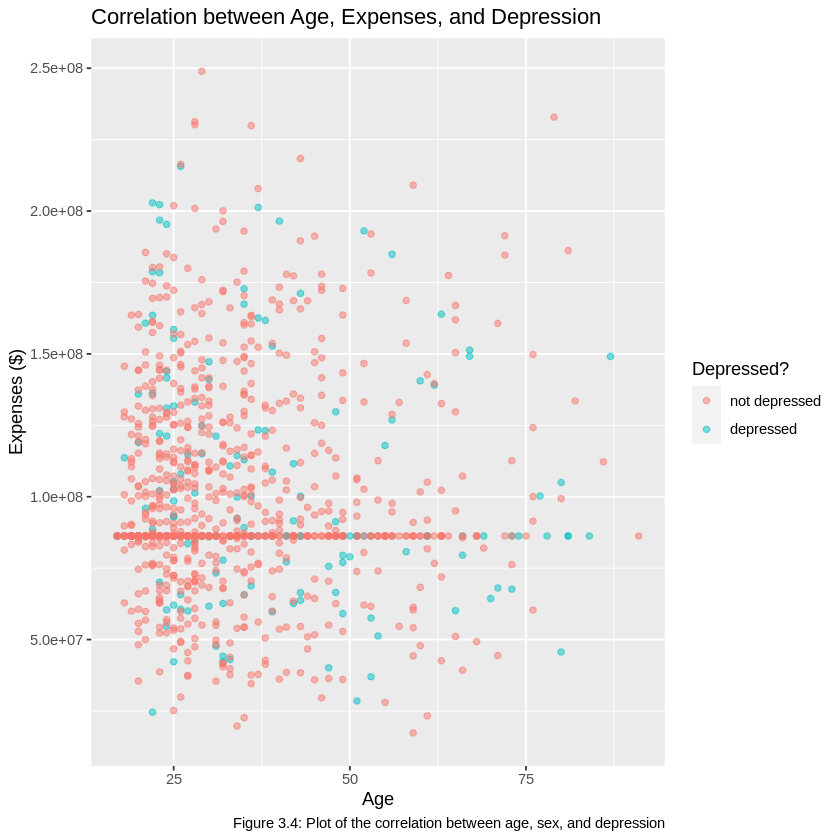

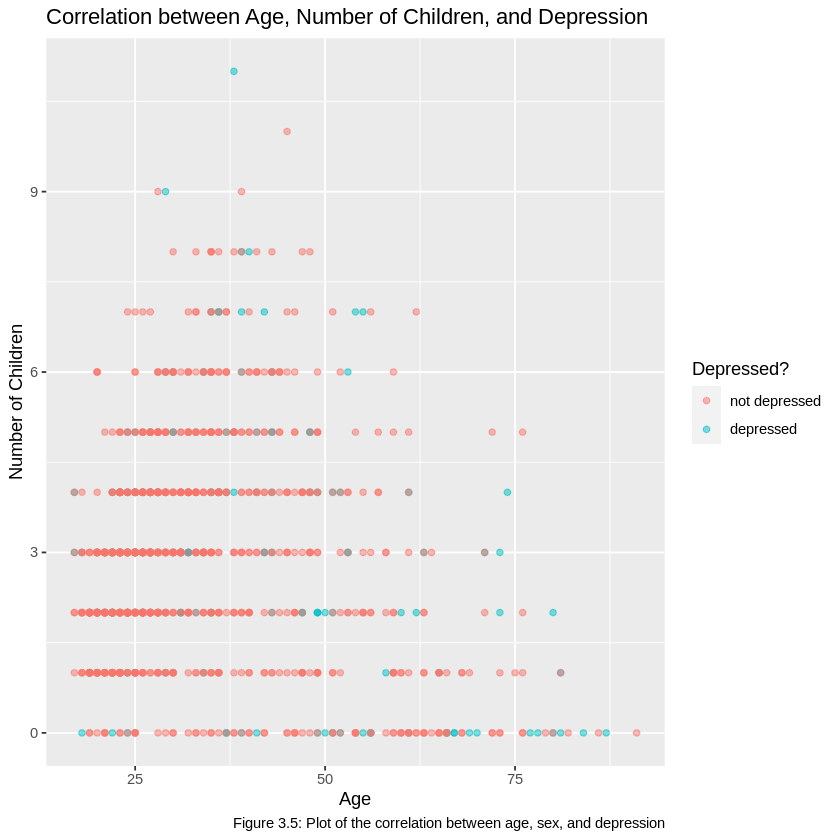

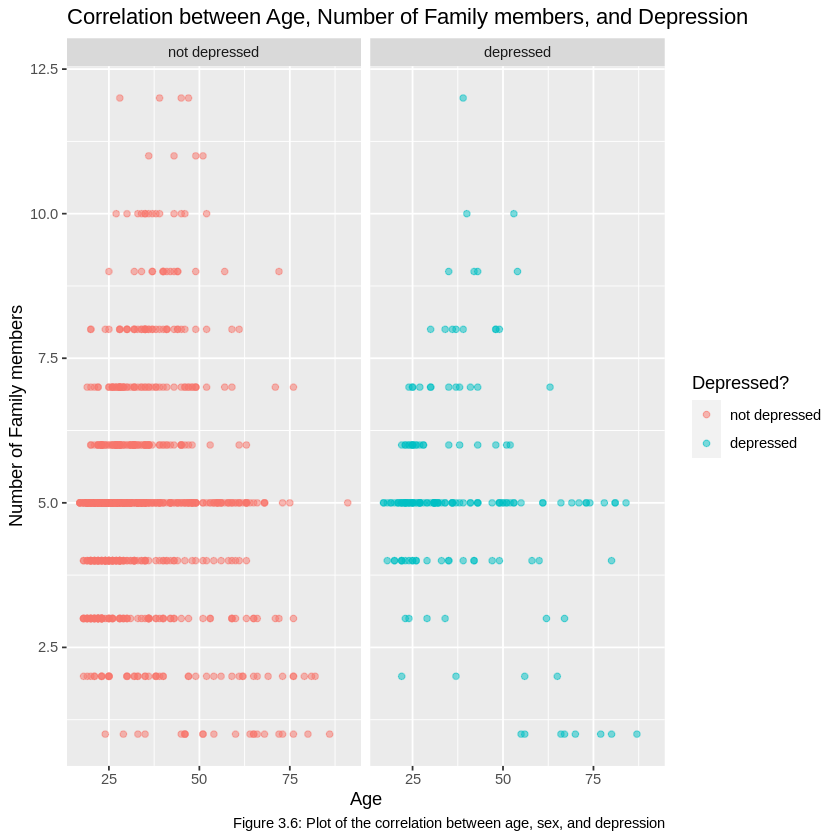

In [4]:
par(mfrow = c(3, 2))  # 3 rows and 2 columns

depression_data_plot1 <- depression_train |>
    ggplot(aes(x=Age, y=sex)) +
    geom_point(aes(color=depression_result), alpha = 0.5) +
    labs(x="Age", y="Sex", color="Depressed?", caption="Figure 3.1: Plot of the correlation between age, sex, and depression") +
    ggtitle("Correlation between Age, Sex, and Depression")
depression_data_plot1

depression_data_plot2 <- depression_train |>
    ggplot(aes(x=Number_children, y=Married)) +
    geom_point(aes(color=depression_result), alpha = 0.5) +
    facet_grid(cols = vars(depression_result)) +
    labs(x="Number of Children", y="Married", color="Depressed?", caption="Figure 3.2: Plot of the correlation between age, sex, and depression") +
    ggtitle("Correlation between Number of Children, Marriage status, and Depression")
depression_data_plot2


depression_data_plot3 <- depression_train |>
    ggplot(aes(x=Age, y=assets)) +
    geom_point(aes(color=depression_result), alpha = 0.5) +
    labs(x="Age", y="Assets ($)", color="Depressed?", caption="Figure 3.3: Plot of the correlation between age, sex, and depression") +
    ggtitle("Correlation between Age, Assets, and Depression")
depression_data_plot3

depression_data_plot4 <- depression_train |>
    ggplot(aes(x=Age, y=expenses)) +
    geom_point(aes(color=depression_result), alpha = 0.5) +
    labs(x="Age", y="Expenses ($)", color="Depressed?", caption="Figure 3.4: Plot of the correlation between age, sex, and depression") +
    ggtitle("Correlation between Age, Expenses, and Depression")
depression_data_plot4

depression_data_plot5 <- depression_train |>
    ggplot(aes(x=Age, y=Number_children)) +
    geom_point(aes(color=depression_result), alpha = 0.5) +
    labs(x="Age", y="Number of Children", color="Depressed?", caption="Figure 3.5: Plot of the correlation between age, sex, and depression") +
    ggtitle("Correlation between Age, Number of Children, and Depression")
depression_data_plot5

depression_data_plot6 <- depression_train |>
    ggplot(aes(x=Age, y=total_members)) +
    geom_point(aes(color=depression_result), alpha = 0.5) +
    facet_grid(cols = vars(depression_result)) +
    labs(x="Age", y="Number of Family members", color="Depressed?", caption="Figure 3.6: Plot of the correlation between age, sex, and depression") +
    ggtitle("Correlation between Age, Number of Family members, and Depression")
depression_data_plot6

# library(patchwork)
# depression_data_plot1 + depression_data_plot2 + depression_data_plot3 + depression_data_plot4 + depression_data_plot5 + depression_data_plot6

### Methods

For our analysis, we will be using the following columns from the dataset:
- sex
- Age
- married
- Number_children
- total_members
- gained_asset
- durable_asset
- save_asset
- living_expenses
- other_expenses
- depressed

To analyze the total assets, we will be using **mutate** function to add the columns *gained_asset*, *durable_asset*, and *save_asset* into one *asset* column.
To analyze the total expenses, we will be using **mutate** function to add the columns *living_expenses* and *other_expenses* into one *expenses* column.

To conduct our data analysis, we will clean our data so it only contains the columns we need, split our dataset into training and testing data, scale our data, use the 5 fold cross-validation technique to find our best k-nearest neighbors, then train our classification model so that it can predict whether someone is depress or not more accurately.

To visualize our results, we will create **scatterplots** of the scaled data using each *predictor* (variable) and colour the points based on whether they are predicted to be depressed or not. If our scatterplot is too difficult to read due to us having too many *predictors*, we will create scatterplots using only 2 predictors and see which ones show the best correlation for predicting depression.

### Expected outcomes and significance

We are expecting to predict whether someone from a rural area is likely to be depressed or not by specifying the factors listed above as predictors into the model.

We expect depression to be more common in women based on statistics from various news articles, people with a lower income to be more at-risk of depression, elderlies with very few family members, and teens with lots of family members, because they may have more pressure or be compared to their siblings a lot.

*Impacts of our findings:*
We are hoping that our findings can help others predict if their family or friends living in rural areas are likely to be depressed, and that our findings can help others in the medical field discover preventive measures that the most vulnerable population could take to reduce the risk of depression (if there are any). We are also hoping that our findings can enchance clinical support to the at-risk population by looking at the roots of why they are more likely to become depressed.

*Future questions our model could reach to:*
- What are some actions that could be taken in general to avoid depression and improve well-being (in relation to each column that are found closely correlated with mental illness)?
- How could the government increase accessibility of the rural community to medical support, especially patients diagnosed with depression?

# Data Analysis

In [5]:
set.seed(2)

# Getting training data
depression_data_split <- initial_split(depression_data, prop=0.75, strata = depression_result)

depression_train <- training(depression_data_split)
depression_test <- testing(depression_data_split)

### Training our classifier

In [6]:
set.seed(1000)

# Getting proportions
proportions <- depression_train |>
                      group_by(depression_result) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(depression_train))

# Creating a recipe
depression_recipe <- recipe(depression_result ~ ., data = depression_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_upsample(depression_result, over_ratio = 1) |>
    prep()

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_fit <- workflow() |>
    add_recipe(depression_recipe) |>
    add_model(knn_spec) |>
    fit(data = depression_train)

depression_test_predictions <- predict(knn_fit, depression_test) |>
    bind_cols(depression_test)

depression_test_predictions

.pred_class,sex,Age,Married,Number_children,total_members,assets,expenses,depression_result
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
not depressed,1,22,1,3,5,75174120,86258781,not depressed
not depressed,1,35,1,6,8,60074152,61134229,not depressed
not depressed,1,21,1,2,4,80383246,175512883,not depressed
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
not depressed,1,34,1,3,5,75174120,86258781,depressed
not depressed,1,25,1,3,5,32316157,89205612,not depressed
not depressed,1,35,1,6,8,58738924,54416665,not depressed


###### Figure 4: Dataset of the testing data with our predicted values

### Computing the accuracy of our model

In [7]:
confusion <- depression_test_predictions |>
             conf_mat(truth = depression_result, estimate = .pred_class)
confusion

depression_test_accuracy <- depression_test_predictions |>
        metrics(truth = depression_result, estimate = .pred_class) |>
        filter(.metric == "accuracy") |>
        select(.estimate) |>
        pull()

cat("\nAccuracy: ", depression_test_accuracy)

               Truth
Prediction      not depressed depressed
  not depressed           214        45
  depressed                84        15


Accuracy:  0.6396648

###### Figure 5: The confusion matrix and accuracy of our model

### Tuning our Classifier

In [8]:
set.seed(2000)

depression_vfold <- vfold_cv(depression_train, v = 5, strata = depression_result)


# Creating a recipe
depression_recipe <- recipe(depression_result ~ ., data = depression_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_upsample(depression_result, over_ratio = 1) |>
    prep()


knn_fit <- workflow() |>
    add_recipe(depression_recipe) |>
    add_model(knn_spec) |>
    fit_resamples(resamples = depression_vfold)

knn_fit |>
    collect_metrics()


.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.6591986,5,0.004557669,Preprocessor1_Model1
roc_auc,binary,0.5114443,5,0.016017641,Preprocessor1_Model1


###### Figure 6: Metrics of our model

### Finding the best number of neighbours K

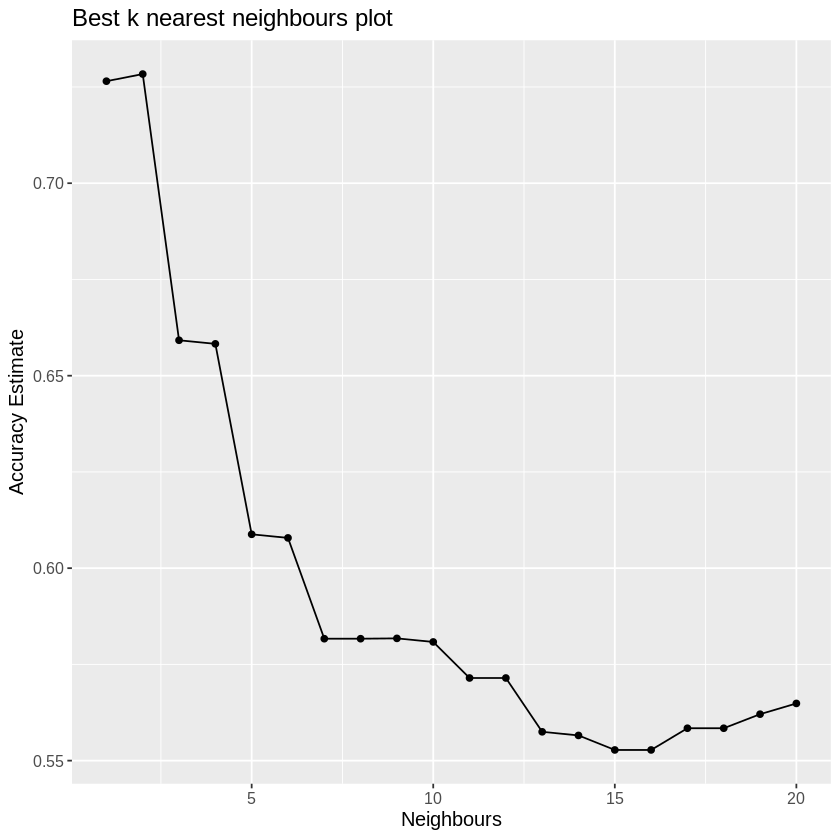

In [9]:
set.seed(4532)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

knn_results <- workflow() |>
    add_recipe(depression_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = depression_vfold, grid = k_vals) |>
    collect_metrics()

accuracies <- knn_results |>
  filter(.metric == "accuracy")

best_k <- accuracies |>
    arrange(desc(mean)) |>
    head(1) |>
    select(neighbors) |>
    pull()

accuracy_vs_k <- accuracies |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbours", y = "Accuracy Estimate") +
    ggtitle("Best k nearest neighbours plot") +
    theme(text = element_text(size = 12))

accuracy_vs_k

###### Figure 7: Plot of knn values vs accuracy estimates

### Retraining our Classifier with the best k value

In [10]:
set.seed(4600)

# Creating a recipe
depression_recipe <- recipe(depression_result ~ ., data = depression_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_upsample(depression_result, over_ratio = 1) |>
    prep()

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_fit <- workflow() |>
    add_recipe(depression_recipe) |>
    add_model(knn_spec) |>
    fit(data = depression_train)

depression_test_predictions <- predict(knn_fit, depression_test) |>
    bind_cols(depression_test)

depression_test_predictions

.pred_class,sex,Age,Married,Number_children,total_members,assets,expenses,depression_result
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
not depressed,1,22,1,3,5,75174120,86258781,not depressed
not depressed,1,35,1,6,8,60074152,61134229,not depressed
not depressed,1,21,1,2,4,80383246,175512883,not depressed
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
not depressed,1,34,1,3,5,75174120,86258781,depressed
not depressed,1,25,1,3,5,32316157,89205612,not depressed
not depressed,1,35,1,6,8,58738924,54416665,not depressed


###### Figure 8: Dataset of the testing data with our predicted values after tuning our model

### Recomputing the accuracy of our model

In [11]:
tuned_depression_test_accuracy <- depression_test_predictions |>
        metrics(truth = depression_result, estimate = .pred_class) |>
        filter(.metric == "accuracy") |>
        select(.estimate) |>
        pull()

confusion <- depression_test_predictions |>
             conf_mat(truth = depression_result, estimate = .pred_class)
confusion

cat("\nAccuracy: ", tuned_depression_test_accuracy)

               Truth
Prediction      not depressed depressed
  not depressed           249        52
  depressed                49         8


Accuracy:  0.7178771

###### Figure 9: The confusion matrix and accuracy of our tuned model

### Classifying using Age, Sex, and Number of children as Predictors


In [12]:
set.seed(2)

# Getting training data
new_depression_data_split <- initial_split(depression_data, prop=0.75, strata = depression_result)

new_depression_train <- training(new_depression_data_split)
new_depression_test <- testing(new_depression_data_split)

### Training our new classifier

In [13]:
set.seed(40)

# Getting proportions
new_proportions <- new_depression_train |>
                      group_by(depression_result) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(new_depression_train))

# Creating a recipe
new_depression_recipe <- recipe(depression_result ~ Age + sex + Number_children, data = new_depression_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_upsample(depression_result, over_ratio = 1) |>
    prep()

new_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
    set_engine("kknn") |>
    set_mode("classification")

new_knn_fit <- workflow() |>
    add_recipe(new_depression_recipe) |>
    add_model(new_knn_spec) |>
    fit(data = new_depression_train)

new_depression_test_predictions <- predict(new_knn_fit, new_depression_test) |>
    bind_cols(depression_test)

new_depression_test_predictions

.pred_class,sex,Age,Married,Number_children,total_members,assets,expenses,depression_result
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
not depressed,1,22,1,3,5,75174120,86258781,not depressed
not depressed,1,35,1,6,8,60074152,61134229,not depressed
not depressed,1,21,1,2,4,80383246,175512883,not depressed
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
not depressed,1,34,1,3,5,75174120,86258781,depressed
not depressed,1,25,1,3,5,32316157,89205612,not depressed
not depressed,1,35,1,6,8,58738924,54416665,not depressed


###### Figure 10: Dataset of the new testing data with our predicted values

### Computing the Accuracy of our new model

In [14]:
new_confusion <- new_depression_test_predictions |>
             conf_mat(truth = depression_result, estimate = .pred_class)
new_confusion

new_depression_test_accuracy <- new_depression_test_predictions |>
    metrics(truth = depression_result, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    select(.estimate) |>
    pull()

cat("\nAccuracy: ", new_depression_test_accuracy)

               Truth
Prediction      not depressed depressed
  not depressed           259        49
  depressed                39        11


Accuracy:  0.7541899

###### Figure 11: The new confusion matrix and accuracy of our model

### Tuning our new Classifier

In [15]:
set.seed(393)

depression_vfold <- vfold_cv(new_depression_train, v = 5, strata = depression_result)

# Creating a recipe
new_knn_depression_recipe <- recipe(depression_result ~ Age + sex + Number_children, data = new_depression_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_upsample(depression_result, over_ratio = 1) |>
    prep()


new_knn_fit <- workflow() |>
    add_recipe(new_knn_depression_recipe) |>
    add_model(new_knn_spec) |>
    fit_resamples(resamples = depression_vfold)

new_knn_fit |>
    collect_metrics()

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.7198733,5,0.01322297,Preprocessor1_Model1
roc_auc,binary,0.5167694,5,0.02489061,Preprocessor1_Model1


###### Figure 12: Metrics of our new model

### Finding the best number of neighbours K for our new classifier

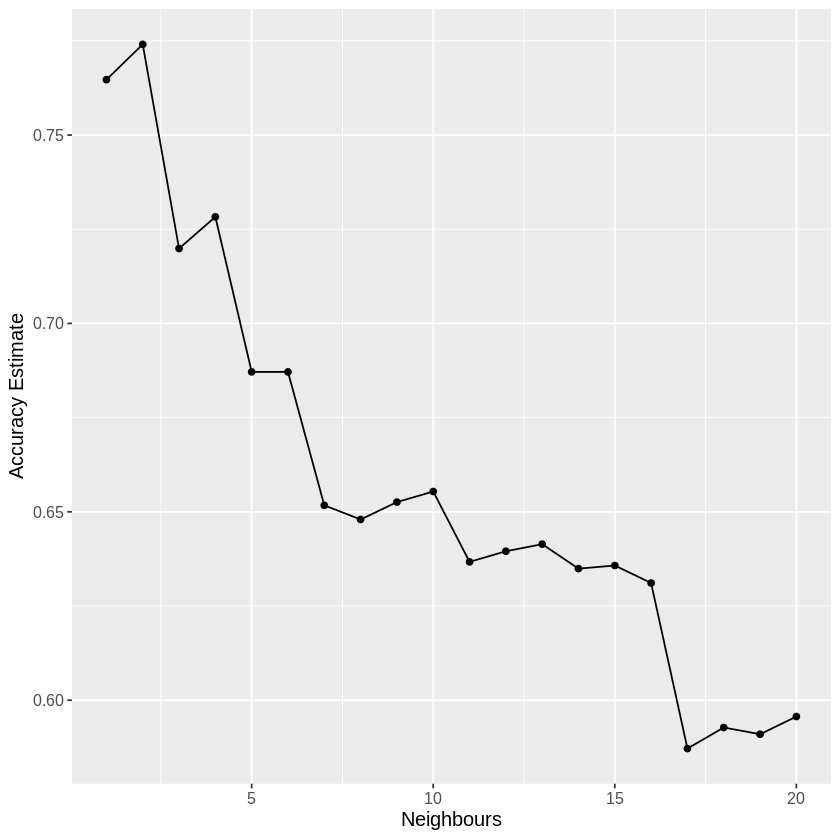

In [16]:
set.seed(3350)

new_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

new_knn_results <- workflow() |>
    add_recipe(new_knn_depression_recipe) |>
    add_model(new_knn_spec) |>
    tune_grid(resamples = depression_vfold, grid = k_vals) |>
    collect_metrics()

new_accuracies <- new_knn_results |>
  filter(.metric == "accuracy")

new_best_k <- new_accuracies |>
    arrange(desc(mean)) |>
    head(1) |>
    select(neighbors) |>
    pull()
    
new_accuracy_vs_k <- new_accuracies |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbours", y = "Accuracy Estimate") +
    theme(text = element_text(size = 12))

new_accuracy_vs_k

###### Figure 13: Plot of knn values vs accuracy estimates

### Retraining our new Classifier with the best k value

In [17]:
set.seed(1250)

# Creating a recipe

new_tuned_depression_recipe <- recipe(depression_result ~ Age + sex + Number_children, data = new_depression_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_upsample(depression_result, over_ratio = 1) |>
    prep()

new_tuned_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = new_best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

new_tuned_knn_fit <- workflow() |>
    add_recipe(new_tuned_depression_recipe) |>
    add_model(new_tuned_knn_spec) |>
    fit(data = new_depression_train)

new_tuned_depression_test_predictions <- predict(new_tuned_knn_fit, new_depression_test) |>
    bind_cols(new_depression_test)

new_tuned_depression_test_predictions

.pred_class,sex,Age,Married,Number_children,total_members,assets,expenses,depression_result
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
not depressed,1,22,1,3,5,75174120,86258781,not depressed
not depressed,1,35,1,6,8,60074152,61134229,not depressed
not depressed,1,21,1,2,4,80383246,175512883,not depressed
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
not depressed,1,34,1,3,5,75174120,86258781,depressed
not depressed,1,25,1,3,5,32316157,89205612,not depressed
not depressed,1,35,1,6,8,58738924,54416665,not depressed


###### Figure 14: Dataset of the testing data with our predicted values after tuning our new model

### Recomputing the accuracy of our new model

In [18]:
new_tuned_confusion <- new_tuned_depression_test_predictions |>
             conf_mat(truth = depression_result, estimate = .pred_class)
new_tuned_confusion

new_tuned_depression_test_accuracy <- new_tuned_depression_test_predictions |>
        metrics(truth = depression_result, estimate = .pred_class) |>
        filter(.metric == "accuracy") |>
        select(.estimate) |>
        pull()

cat("\nAccuracy: ", new_tuned_depression_test_accuracy)

               Truth
Prediction      not depressed depressed
  not depressed           283        54
  depressed                15         6


Accuracy:  0.8072626

###### Figure 15: The confusion matrix and accuracy of our new tuned model

## Summary

Based on the classification results, we managed to compute the classifier we built on the test data with 80.73% accuracy after refining and reselecting our variables. Some of the predictors selected in the beginning might not be directly related to depression as shown by the scatterplots. The correlation is weak and does not strongly support that these variables could cause depression or prevent someone from depression. We filtered only three variables out of the six that we chose in the beginning, namely "Age", "Sex", and "the number of children". As shown in the confusion matrix, the updated model succeed to make 6 correct predictions of one being depressed, and 283 correct predictions of a non-depressed person. In cases of misinterpretations, 54 "depressed" individuals were incorrectly classified as "not depressed" and another 15 "not depressed" were mistakenly identified as "depressed". This model is better at predicting depression based on the percentage of observations that were correctly predicted as non-depressed individuals. The main reason could be the randomness of the variables in the first model that interfere with the prediction process. It is also hard to take all 6 variables into account. By reselecting the 3 most relatable predictors, we are able to build a better classifcation model. Although the new model still had a few errors in predicting depression, it provides a rough estimate of whether or not an individual is vulnerable to depression. The model is better at predicting "not depressed" individuals and could be useful in eliminating the tested person from depression. The only risk is that a depressed individual may be classified as "not depressed" and may not be able to look into the matter sooner as they could have. 